## Corriente de electrones en sistemas abiertos de dos puntos cuánticos

In [2]:
pip install qutip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 6.6 MB/s eta 0:00:00


In [17]:
from joblib import delayed, Parallel

from tqdm.auto import tqdm
import numpy as np

import qutip as qt
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

El Hamiltoniano del sistema en la base $\mathscr{B}=\{\ket{\varnothing}, \ket{L}, \ket{R}\}$:

$H= \begin{pmatrix}
        0 & 0 & 0 \\
        0 & \delta/2 & \tau/2 \\
        0 & \tau/2 & -\delta/2
    \end{pmatrix}$

In [5]:
# parámetros del sistema
t = np.linspace(0, 100, 1000)

In [6]:
E = qt.basis(3, 0)
L = qt.basis(3, 1)
R = qt.basis(3, 2)

In [20]:
gammaL = 0.05
gammaR = 0.05
psi0 = E

c1 = qt.Qobj(np.array([(0,1,0),(0,0,0),(0,0,0)]))
c2 = qt.Qobj(np.array([(0,0,1),(0,0,0),(0,0,0)]))

L1 = gammaL*c1
L2 = gammaR*c2

c_ops = [(L1).dag(),L2]

La corriente que se medirá vendrá dada por $I=e\rho_{RR}\Gamma_R$. Hacemos $\Gamma_R=\Gamma_L$.

In [21]:
def pixel(delta, tau):
    H = qt.Qobj(np.array([(0,0,0),(0,delta/2,tau/2), (0,tau/2,-delta/2)]))
    state = qt.mesolve(H, psi0, t, c_ops, []).states
    pRs = []
    for time in range(len(t)):
        pRs.append(np.abs(R.overlap(state[time]))**2)
    pRmax = max(pRs)
    return pRmax

In [27]:
# pintamos la corriente normalizada (I=rho_RR) frente al detuning
w = 1
deltas = np.linspace(-6*w, 6*w, 101)
taus = np.linspace(0, 6, 101)

deltas_mat = []
taus_mat = []

for i in range(len(deltas)):
     for j in range(len(taus)):
        taus_mat.append(taus[j])
        deltas_mat.append(deltas[i])

In [28]:
pbar = tqdm(range(len(deltas_mat)), desc='Calculando...')
resultados = Parallel(n_jobs=16)(delayed(pixel)(deltas_mat[i], taus_mat[i]) for i in pbar)
np.save('current_dqd.npy', resultados)

Calculando...:   0%|          | 0/10201 [00:00<?, ?it/s]

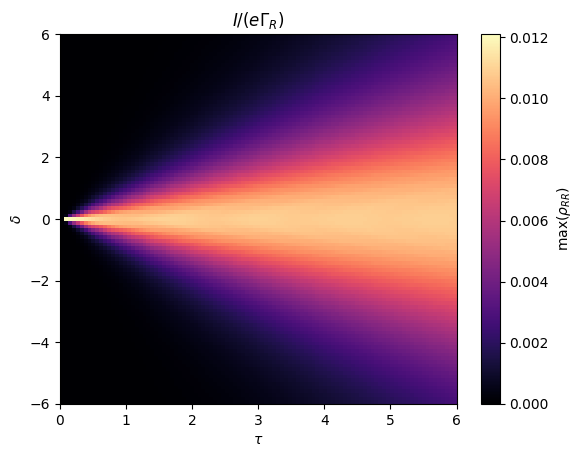

In [31]:
resultados_mat = np.array(resultados).reshape((len(deltas), len(taus)))

fig, ax = plt.subplots()
im = ax.imshow(resultados_mat, cmap = 'magma', origin='lower', aspect='auto',
                interpolation='none', extent=[min(taus) / w, max(taus) / w, min(deltas) / w, max(deltas) / w])
plt.ylabel(r'$\delta$')
plt.xlabel(r'$\tau$')
plt.title(r'$I/(e\Gamma_R)$')
cbar = plt.colorbar(im)
cbar.ax.set_ylabel(r'$\max(\rho_{RR})$')

plt.savefig('current_dqd')